In [2]:
import numpy as np
import pandas as pd
import pybrain

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
import PIL
pylab.rcParams['figure.figsize']= 16,5

In [4]:
from pybrain import FeedForwardNetwork
from pybrain import LinearLayer,SigmoidLayer
from pybrain import FullConnection
from pybrain.supervised.trainers import BackpropTrainer
from pybrain import datasets

implementar SKLEARN para el procesamiento paralelo

In [5]:
rawData = pd.read_csv('resources/Consulta_Banxico.csv', sep=',', encoding='latin1', skiprows=16, skip_blank_lines=True)
column = rawData.columns.values
rawData
Data = rawData.drop(rawData.index[:2])
Data = Data.reset_index(drop = True)
Data.columns = ['Fecha' , 'Tasa de crecimiento Mensual']

Se eliminan los 2 primeros indices debido a que no son utiles ( es texto y la primera observación no tiene valor) y se crea la estructura de Serie (para la serie de tiempo)

In [6]:
TS = pd.Series(Data['Tasa de crecimiento Mensual'].astype(float))

In [7]:
TS.index= Data['Fecha']

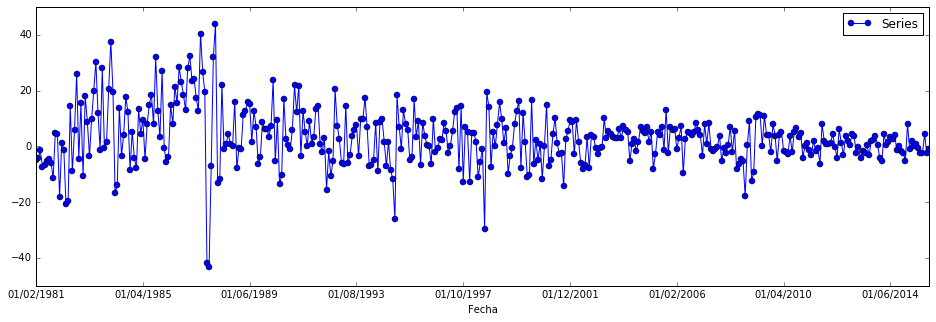

In [8]:
plt.figure()
TS.plot(style='o-', label = 'Series')
plt.legend()

In [9]:
def buildFFN(inNeurons,hiddenNeurons):
    ffn = FeedForwardNetwork()
    inLayer = LinearLayer(inNeurons)
    hiddenLayer = SigmoidLayer(hiddenNeurons)
    outLayer = LinearLayer(1)
    ffn.addInputModule(inLayer)
    ffn.addModule(hiddenLayer)
    ffn.addOutputModule(outLayer)
    in_to_hidden = FullConnection(inLayer,hiddenLayer)
    hidden_to_out = FullConnection(hiddenLayer,outLayer)
    ffn.addConnection(in_to_hidden)
    ffn.addConnection(hidden_to_out)
    ffn.sortModules()
    return ffn

In [10]:
def create_DataMatrix_Output(values,TS, lags):
    dataSet = np.zeros((len(values)-(lags), lags))
    for x in xrange(len(values)-(lags)):
        dataSet[x] = values[x: x+lags]
    output = TS[lags:]    
    return dataSet,output

In [11]:
def create_DS(dataMatrix,output,lags):
    DS = datasets.SupervisedDataSet(12, 1)
    for x in xrange(len(dataMatrix)):
        DS.appendLinked(dataMatrix[x], output[x])
    return DS

In [18]:
lags = 12

In [19]:
dataM, output = create_DataMatrix_Output(Data['Tasa de crecimiento Mensual'],TS,lags)
TrainM = dataM[:(len(dataM)-2*12)]
TrainO = output[:(len(dataM)-2*12)]
ValM = dataM[(len(dataM)-2*12):(len(dataM)-12)]
ValO = output[(len(dataM)-2*12):(len(dataM)-12)]
##TestM = dataM[(len(dataM)-lags):]
##TestO = output[(len(dataM)-lags):]

In [20]:
def create_DataSets(lags):
    dataM, output = create_DataMatrix_Output(Data['Tasa de crecimiento Mensual'],TS,lags)
    TrainM = dataM[:(len(dataM)-2*12)]
    TrainO = output[:(len(dataM)-2*12)]
    ValM = dataM[(len(dataM)-2*12):(len(dataM)-12)]
    ValO = output[(len(dataM)-2*12):(len(dataM)-12)]
    TrainDS = create_DS(TrainM,TrainO,lags)
    ValDS = create_DS(ValM,ValO,lags)
    return TrainDS,ValDS,ValO

In [21]:
def trainFNN(ffn,TrainDS,LearnRate,MaxEpochs):
    trainer = BackpropTrainer(ffn, TrainDS,learningrate = LearnRate )
    trainer.trainUntilConvergence(verbose= False, maxEpochs=MaxEpochs,validationProportion= 0.1,continueEpochs= 10)
    return ffn

In [22]:
def get_ValPredictions(ffn,ValDS):
    predictions = ffn.activateOnDataset(ValDS)
    predictions = predictions.reshape(1,12)
    return predictions

In [23]:
def get_MSE(predictions, output):
    return  np.mean(np.sum((output - predictions)**2))

In [24]:
def ValidationTest(ffn, ValDS,output, lags):
    predictions = ffn.activateOnDataset(ValDS)
    predictions = predictions.reshape(1,lags)
    mse = get_MSE(predictions[0],output)
    return mse

In [25]:
def SolutionValidation(meanPredictions,mse,bestFFN,bestMSE,bestPredictions,lags,an,maxE,LearnR):
        if(mse < bestMSE):
            bestFFN = [lags,an,maxE,LearnR]
            bestMSE = mse
            bestPredictions = meanPredictions
        return bestMSE,bestFFN, bestPredictions

In [26]:
def Validation(ParametersList):
    bestParameters = [len(ParametersList)]
    bestRNA = []
    bestMSE = 10000000000000000
    bestPredicts = []
    for lags in ParametersList[0]:    
        TrainDS,ValDS,ValOutput = create_DataSets(lags)
        for an in ParametersList[1]:
            ffn = buildFFN(lags,an)
            for maxE in ParametersList[2]:
                for learnR in ParametersList[3]:
                    trainFNN(ffn,TrainDS,learnR,maxE)
                    MSEsum = 0 
                    sumPredictions = np.zeros((1,lags))
                    for epoch in xrange(100):
                        predictions = get_ValPredictions(ffn,ValDS)
                        mse = ValidationTest(ffn, ValDS,ValOutput, lags)
                        MSEsum += mse
                        sumPredictions += predictions
                    MSEmean = MSEsum / 100
                    MeanPredictions = sumPredictions / 100
                    bestMSE,bestRNA,bestPredicts = SolutionValidation(MeanPredictions,MSEmean,bestRNA,bestMSE,bestPredicts,lags,an,maxE,learnR)
    return bestRNA, MSEmean, bestPredicts

In [27]:
ParametersList = [[12],[3],[1000],[0.1]]

In [28]:
lags = 12
TrainDS1, ValDS1, ValOutput1 = create_DataSets(lags)
ffn = buildFFN(lags,3)

In [53]:
MSEsum = 0
sumPredictions = np.zeros((1,lags))
Predicts = np.zeros((100,lags))
for epoch in xrange(100):
    ffn = trainFNN(ffn,TrainDS1,0.1,1000)
    predictions = get_ValPredictions(ffn,ValDS1)
    Predicts[epoch]  = predictions
    mse = ValidationTest(ffn, ValDS1,ValOutput1, lags)
    MSEsum += mse
    sumPredictions += predictions
MSEmean = MSEsum / 100
MeanPredictions = sumPredictions / 100

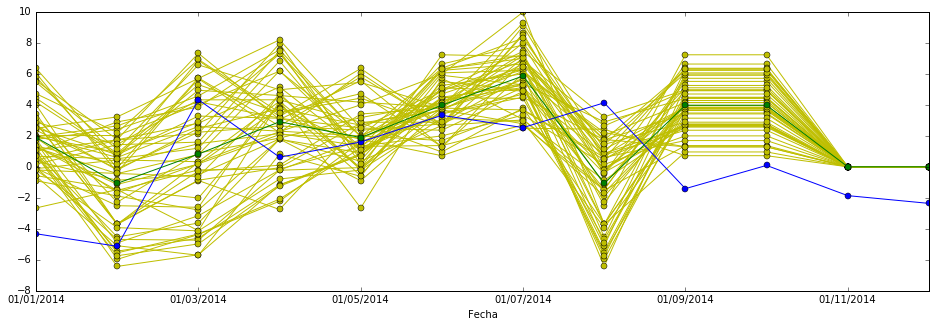

In [54]:
fig100 = plt.figure()
for x in Predicts:
    TSValPredictions = pd.Series(x.astype(float), index = TS.index[len(TS)-24:len(TS)-12])
    TSValPredictions.plot(style = 'yo-', label = ("Predicctions " + (str)(x)))
TSValOutputs = pd.Series(ValOutput1, index = TS.index[len(TS)-24:len(TS)-12])
TSValOutputs.plot(style= 'o-', label = "True Values")
TSMeanPred = pd.Series(MeanPredictions[0].astype(float), index = TS.index[len(TS)-24:len(TS)-12])
TSMeanPred.plot(style= 'o-', label = "True Values")

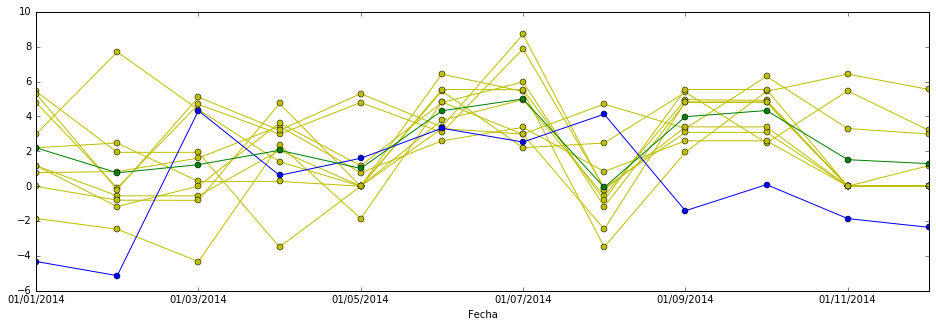

In [37]:
Predicts10 = Predicts
MeanPredictions10 = MeanPredictions
MSEmean10 = MSEmean
fig10

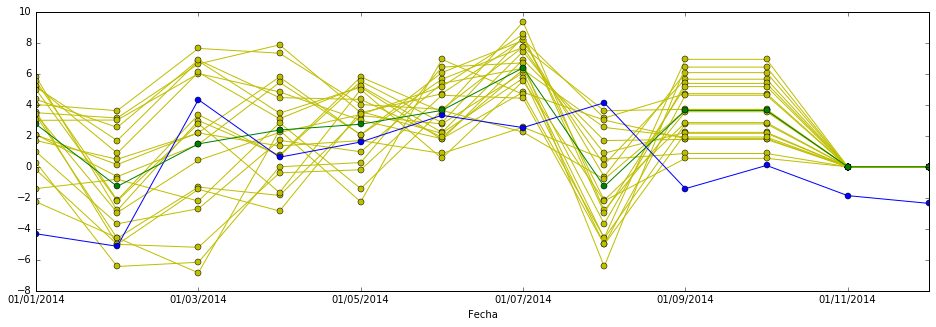

In [46]:
Predicts20 = Predicts
MeanPredictions20 = MeanPredictions
MSEmean20 = MSEmean
fig20

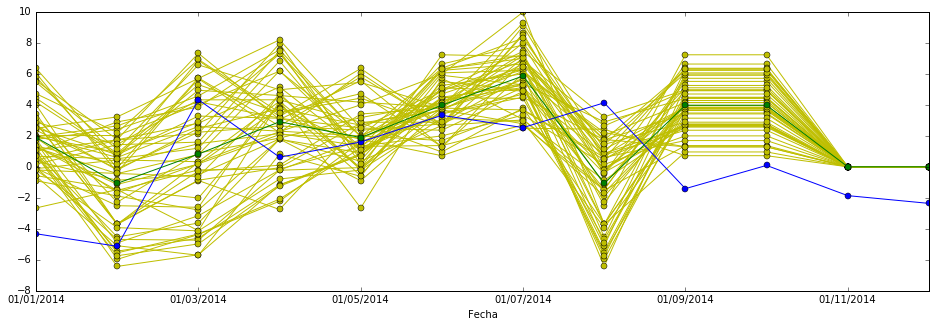

In [56]:
Predicts50 = Predicts
MeanPredictions50 = MeanPredictions
MSEmean50 = MSEmean
fig50